In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH = '/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


In [ ]:
# This cell prepares the Colab environment by copying and
# extracting the dataset from Google Drive to the fast local SSD.

import os
import time

# --- Part 1: Colab Local Data Setup ---
print("Starting data setup...")
start_setup_time = time.time()

# --- Define paths ---
DRIVE_ARCHIVE_PATH = "/content/drive/MyDrive/datasets/cropped_celeba.tar"
LOCAL_ARCHIVE_PATH = "/content/cropped_celeba.tar"
EXTRACT_PATH = "/content/celeba_dataset"

# The final, correct path to the images, based on our investigation
LOCAL_DATA_DIR = os.path.join(EXTRACT_PATH, "content", "cropped_celeba")

# --- Logic ---
# Only copy/untar if the local data directory doesn't already exist
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying {DRIVE_ARCHIVE_PATH} to local runtime...")
    if not os.path.exists(DRIVE_ARCHIVE_PATH):
        print(f"[FATAL ERROR] Source file not found: {DRIVE_ARCHIVE_PATH}")
        raise FileNotFoundError(f"Source file not found: {DRIVE_ARCHIVE_PATH}")

    # 1. Copy the single .tar file from Drive (fast)
    !cp "{DRIVE_ARCHIVE_PATH}" "{LOCAL_ARCHIVE_PATH}"
    print("Copy complete.")

    # 2. Extract the archive to the local SSD (fast)
    print(f"Untarring {LOCAL_ARCHIVE_PATH} to {EXTRACT_PATH}...")
    !mkdir -p "{EXTRACT_PATH}"
    !tar -xf "{LOCAL_ARCHIVE_PATH}" -C "{EXTRACT_PATH}"
    print("Untar complete.")

    # 3. Clean up the local archive to save space
    !rm "{LOCAL_ARCHIVE_PATH}"
else:
    print(f"Data directory {LOCAL_DATA_DIR} already exists. Skipping copy/untar.")

print(f"Data setup finished in {time.time() - start_setup_time:.2f} seconds.")

# --- Sanity Check ---
# Crucial check to ensure data exists before proceeding
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"\n[FATAL ERROR] The expected data directory does not exist: {LOCAL_DATA_DIR}")
    raise FileNotFoundError(f"Could not find data at {LOCAL_DATA_DIR}")
else:
    print(f"Successfully found data at: {LOCAL_DATA_DIR}")

Starting data setup...
Copying /content/drive/MyDrive/datasets/cropped_celeba.tar to local runtime...
Copy complete.
Untarring /content/cropped_celeba.tar to /content/celeba_dataset...
Untar complete.
Data setup finished in 34.93 seconds.
Successfully found data at: /content/celeba_dataset/content/cropped_celeba


In [ ]:
import torch
import sys

from src.utils.data_utils import get_dataloaders

# --- Configuration ---
# Use the local data path defined in Cell 1
DATA_ROOT = LOCAL_DATA_DIR
BATCH_SIZE = 256
IMAGE_SIZE = 128
RANDOM_SEED = 42

# --- 1. Get Dataloaders ---
# This single function call does all the work
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=DATA_ROOT,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    random_seed=RANDOM_SEED
)

# --- 2. Verification ---
# Final check to ensure the dataloader works
if train_loader:
    print("\nVerifying one batch from train_loader...")
    try:
        # Get one sample batch
        images, labels = next(iter(train_loader))
        print(f"  Batch loaded successfully.")
        print(f"  Image batch shape: {images.shape}")
        print("\nSetup complete. You are ready to start training.")
    except Exception as e:
        print(f"  [Error] Failed to load batch: {e}")
else:
    print("\nData loading failed. Please check previous cell output.")


Loading dataset from: /content/celeba_dataset/content/cropped_celeba
Searching for '*.jpg' files in: /content/celeba_dataset/content/cropped_celeba
Successfully found 199509 images.
Successfully loaded 199509 total images.
Splitting dataset into:
  Train: 159607 images
  Validation: 19950 images
  Test: 19952 images

DataLoaders created successfully.

Verifying one batch from train_loader...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Batch loaded successfully.
  Image batch shape: torch.Size([256, 3, 128, 128])

Setup complete. You are ready to start training.


Randomly selected validation indices: [2609, 425, 10322, 8378]
Successfully loaded 4 specific images from VAL_DATASET.

--- Processing Model: face_autoencoder_512.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_SSIM.pth ---
Model loaded successfully.


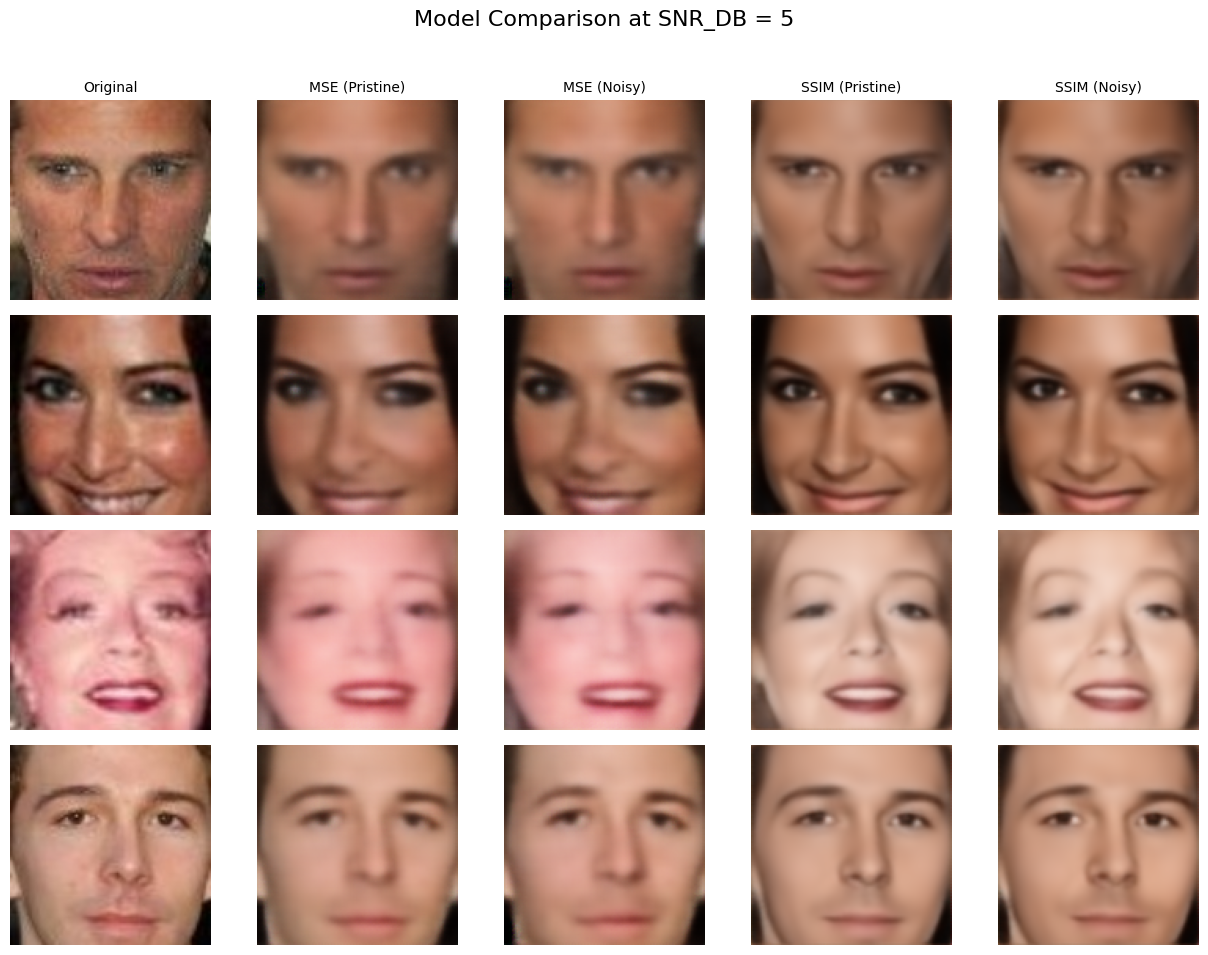

In [27]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from src.utils.channels import awgn_channel
from src.utils.viz_utils import render_tensor
from src.models.face_autoencoder import FaceAutoencoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
VISUALIZE_SNR_DB = 5
NUM_IMAGES_TO_SHOW = 4

MODEL_CONFIGS = [
    (512, "_512.pth", "MSE"),
    (512, "_512_SSIM.pth", "SSIM")
]

try:
    val_subset = val_loader.dataset
    full_dataset = val_subset.dataset

    validation_indices = val_subset.indices

    # 89, 105 - 밝은 경우
    # 17, 104 - 선글라스
    # 2001 -  콧수염, 홍조
    # 10000 -  안경
    max_index = len(validation_indices) - 1
    IMAGE_INDICES_TO_SHOW = random.sample(range(max_index), k=4)
    print(f"Randomly selected validation indices: {IMAGE_INDICES_TO_SHOW}")

    image_list = []
    for idx in IMAGE_INDICES_TO_SHOW:
        original_idx = validation_indices[idx]
        image_tensor = full_dataset[original_idx][0]
        image_list.append(image_tensor)

    sample_images = torch.stack(image_list).to(device)

    print(f"Successfully loaded {len(sample_images)} specific images from VAL_DATASET.")

except NameError:
    print("[ERROR] val_loader is not defined. Please run the Dataloader setup cell first.")
except IndexError:
    print(f"[ERROR] Index out of range. 'IMAGE_INDICES_TO_SHOW' values must be less than {len(validation_indices)}")
except Exception as e:
    print(f"An error occurred: {e}")

# --- 각 모델별 복원 결과를 저장 ---
reconstruction_results = {}

for latent_dim, suffix, display_name in MODEL_CONFIGS:
    model_name = f"face_autoencoder{suffix}"
    MODEL_PATH = os.path.join(SAVE_DIR, model_name)
    print(f"\n--- Processing Model: {model_name} ---")

    model = FaceAutoencoder(latent_dim=latent_dim).to(device)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval()
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"[ERROR] Model file not found at {MODEL_PATH}. Skipping.")
        reconstruction_results[display_name] = {'pristine': None, 'noisy': None}
        continue

    with torch.no_grad():
        latent_original = model.encode(sample_images)
        latent_noisy = awgn_channel(latent_original, snr_db=VISUALIZE_SNR_DB)
        recon_pristine = model.decode(latent_original)
        recon_noisy = model.decode(latent_noisy)
        reconstruction_results[display_name] = {
            'pristine': recon_pristine,
            'noisy': recon_noisy
        }

# --- 하나의 큰 그림으로 모든 결과 플로팅 (Side-by-Side) ---
num_cols_per_image = 1 + len(MODEL_CONFIGS) * 2
num_rows = NUM_IMAGES_TO_SHOW

fig, axes = plt.subplots(num_rows, num_cols_per_image, figsize=(num_cols_per_image * 2.5, num_rows * 2.5))
fig.suptitle(f"Model Comparison at SNR_DB = {VISUALIZE_SNR_DB}", fontsize=16)

# --- 각 열의 헤더(제목) 정의 ---
column_titles = ["Original"]
for _, _, display_name in MODEL_CONFIGS:
    column_titles.append(f"{display_name} (Pristine)")
    column_titles.append(f"{display_name} (Noisy)")

# --- 이미지 플로팅 ---
for row_idx in range(NUM_IMAGES_TO_SHOW):

    # 1. 원본 이미지 (첫 번째 열)
    render_tensor(axes[row_idx, 0], sample_images[row_idx],
           title=column_titles[0] if row_idx == 0 else None)

    col_offset = 1
    for _, _, display_name in MODEL_CONFIGS:
        recons = reconstruction_results.get(display_name, {'pristine': None, 'noisy': None})

        # 2. Pristine 복원
        if recons['pristine'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['pristine'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 3. Noisy 복원
        if recons['noisy'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['noisy'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Loading model: face_autoencoder_512_SSIM.pth...
Model loaded successfully.
Initializing Face Detector (YuNet)...
이미지를 업로드해주세요.


Saving smiling-asian-young-woman-face-portrait_53876-145636.jpg to smiling-asian-young-woman-face-portrait_53876-145636.jpg

--- Original Image (1 face(s) detected) ---


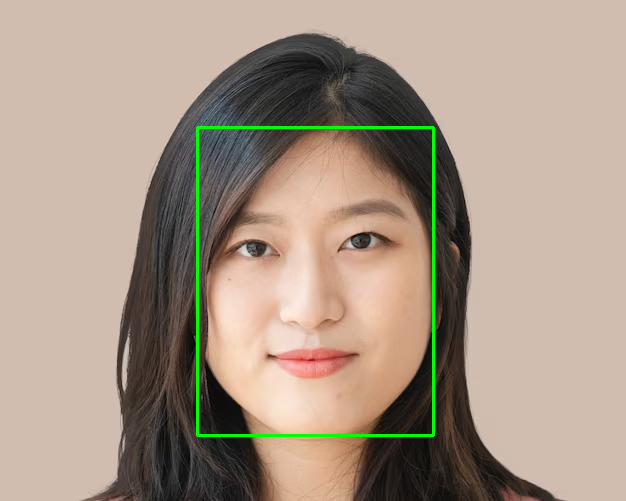


--- Processing 1 detected face(s) ---

Processing Face #1...


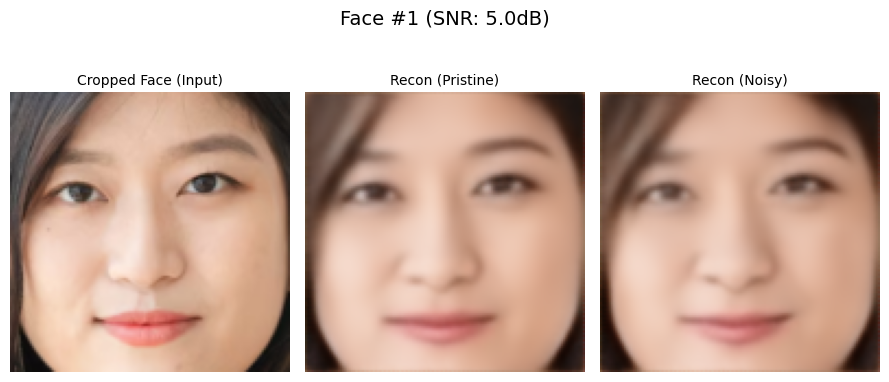

In [37]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# --- 1. (필수) src 폴더 경로 설정 ---
import sys
PROJECT_ROOT = "/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design"
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    print(f"Added '{SRC_PATH}' to Python path")

# --- 2. 모듈 임포트 ---
from google.colab.patches import cv2_imshow # 👈 원본+박스 표시용
from src.utils.channels import awgn_channel
from src.utils.viz_utils import render_tensor
from src.models.face_autoencoder import FaceAutoencoder
from src.utils.data_utils import get_transform
from src.utils.io_utils import get_image_from_upload
from src.models.face_detector import FaceDetector # 👈 YuNet 탐지기
from src.utils.viz_utils import draw_bounding_boxes # 👈 BBox 그리기

# -----------------------------------------------
# 3. 테스트 설정
# -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
VISUALIZE_SNR_DB = 5.0 # 테스트할 노이즈 강도

MODEL_TO_TEST = "face_autoencoder_512_SSIM.pth" # 👈 테스트할 최종 모델
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_TO_TEST)
MODEL_LATENT_DIM = 512

# -----------------------------------------------
# 4. 모델 및 얼굴 탐지기 로드
# -----------------------------------------------
print(f"Loading model: {MODEL_TO_TEST}...")
model = FaceAutoencoder(latent_dim=MODEL_LATENT_DIM).to(device)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"[FATAL ERROR] Model file not found at {MODEL_PATH}")

print("Initializing Face Detector (YuNet)...")
face_detector = FaceDetector()
transform = get_transform(image_size=128)

# -----------------------------------------------
# 5. 이미지 업로드 및 얼굴 탐지
# -----------------------------------------------
original_image = get_image_from_upload() # (BGR NumPy 이미지 반환)

if original_image is not None:

    # 1. 원본 이미지에서 얼굴 탐지 실행
    cropped_faces, final_boxes = face_detector.run(
        original_image,
        target_size=640,
        score_threshold=0.7
    )

    # 2. 원본 + 바운딩 박스 그리기 및 출력
    img_with_boxes = draw_bounding_boxes(original_image, final_boxes)
    print(f"\n--- Original Image ({len(cropped_faces)} face(s) detected) ---")
    cv2_imshow(img_with_boxes) # 👈 (원본 + 박스) 첫 번째 출력

    # 3. (NEW) 감지된 모든 얼굴에 대해 루프 실행
    if not cropped_faces:
        print("Could not detect a face in the uploaded image.")
    else:
        print(f"\n--- Processing {len(cropped_faces)} detected face(s) ---")

        for i, face_bgr in enumerate(cropped_faces):
            print(f"\nProcessing Face #{i+1}...")

            # -----------------------------------------------
            # 6. (NEW) 각 얼굴별로 전처리 및 복원
            # -----------------------------------------------

            # a. BGR -> PIL (RGB) -> Transform -> Tensor
            face_pil = Image.fromarray(cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB))
            input_tensor = transform(face_pil)
            sample_image = input_tensor.unsqueeze(0).to(device)

            # b. 오토인코더 실행
            with torch.no_grad():
                latent_original = model.encode(sample_image)
                latent_noisy = awgn_channel(latent_original, snr_db=VISUALIZE_SNR_DB)
                recon_pristine = model.decode(latent_original)
                recon_noisy = model.decode(latent_noisy)

            # c. (NEW) 각 얼굴별로 1x3 격자 생성 및 출력
            fig, axes = plt.subplots(1, 3, figsize=(9, 4))
            fig.suptitle(f"Face #{i+1} (SNR: {VISUALIZE_SNR_DB}dB)", fontsize=14)

            render_tensor(axes[0], sample_image[0], title="Cropped Face (Input)")
            render_tensor(axes[1], recon_pristine[0], title="Recon (Pristine)")
            render_tensor(axes[2], recon_noisy[0], title="Recon (Noisy)")

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show() # 👈 루프 안에서 각 얼굴마다 플롯 출력